<a href="https://colab.research.google.com/github/rmisra095/facial/blob/main/Final_Facial_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing torch dependencies
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

# Device configuration: Use cuda if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Download latest version of dataset (data is already cleansed and tranformed)
import kagglehub
# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/msambare/fer2013/versions/1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Data Preparation

import torchvision
from torch.utils.data import DataLoader, Subset

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 32

train_dir = "/root/.cache/kagglehub/datasets/msambare/fer2013/versions/1/train"
test_dir = "/root/.cache/kagglehub/datasets/msambare/fer2013/versions/1/test"

# load train and test datasets
trainset = torchvision.datasets.ImageFolder(root=train_dir, transform=transform)
testset = torchvision.datasets.ImageFolder(root=test_dir, transform=transform)

# Create subsets
subset_size = 1000
train_subset = Subset(trainset, indices=list(range(subset_size)))
test_subset = Subset(testset, indices=list(range(subset_size)))

trainloader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(dataset=test_subset, batch_size=batch_size, shuffle=False, num_workers=2)
classes = trainset.classes

print("Classes:", classes)
print("Number of training samples in subset:", len(train_subset))
print("Number of test samples in subset:", len(test_subset))

example_image, example_label = train_subset[212]
print("Example label:", example_label)

Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Number of training samples in subset: 1000
Number of test samples in subset: 1000
Example label: 0


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the CNN model
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # First convolution with batch normalization (for grayscale images)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        # Second convolution with batch normalization
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        # Third convolution with batch normalization
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 6 * 6, 128)  # Adjust size for 48x48 input images
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 7)  # Output layer for 7 classes

    def forward(self, x):
        # Successive convolutions, batch normalization, and pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        # Flatten all dimensions except batch
        x = torch.flatten(x, 1)
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# Instantiating Model
model = Net().to(device)

# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
#Training Loop

from torch.utils.data import random_split, Subset

total_data_points = 1000

subset_indices = list(range(total_data_points))
limited_trainset = Subset(trainset, subset_indices)

# Split the subset into training and validation subsets
train_size = int(0.8 * len(limited_trainset))
val_size = len(limited_trainset) - train_size
train_subset, val_subset = random_split(limited_trainset, [train_size, val_size])

trainloader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(dataset=val_subset, batch_size=batch_size, shuffle=False)

num_epochs = 2

# Model Training and Validation Loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Training loop
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_loss/len(trainloader):.4f}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss/len(valloader):.4f}")


Epoch [1/2], Training Loss: 0.0000
Epoch [1/2], Validation Loss: 0.0000
Epoch [2/2], Training Loss: 0.0000
Epoch [2/2], Validation Loss: 0.0000


In [ ]:
# Evaluating the Model

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 100.00%


In [ ]:
# Define emotion classes
classes = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Neutral",
    5: "Sad",
    6: "Surprise"
}

# Initialize dictionaries to count correct predictions
correct_pred = {classname: 0 for classname in classes.values()}
total_pred = {classname: 0 for classname in classes.values()}

# Evaluate model accuracy
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)

        # collect predictions for each class
        for label, prediction in zip(labels, predictions):
            class_name = classes[label.item()]
            if label == prediction:
                correct_pred[class_name] += 1
            total_pred[class_name] += 1

# accuracy for each emotion
for classname, correct_count in correct_pred.items():
    if total_pred[classname] > 0:
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class {classname:10s}: {accuracy:.1f} %')
    else:
        print(f'Accuracy for class {classname:10s}: No samples')


Accuracy for class Angry     : 100.0 %
Accuracy for class Disgust   : No samples
Accuracy for class Fear      : No samples
Accuracy for class Happy     : No samples
Accuracy for class Neutral   : No samples
Accuracy for class Sad       : No samples
Accuracy for class Surprise  : No samples


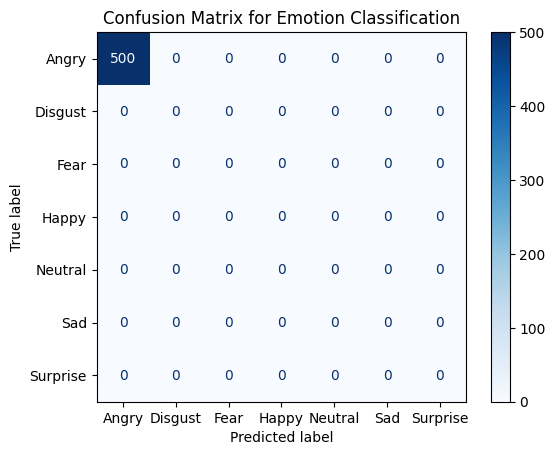

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define emotion classes
classes = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Neutral",
    5: "Sad",
    6: "Surprise"
}

# store all true labels and predictions
all_labels = []
all_predictions = []

model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predictions = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions, labels=list(classes.keys()))

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=list(classes.values()))  # Use emotion names as labels
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Emotion Classification")
plt.show()

